In [11]:
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt

In [12]:
# Rastrigin function for optimization
def rastrigin(x):
    n = len(x)
    A = 10
    return A * n + sum([(xi ** 2 - A * np.cos(2 * np.pi * xi)) for xi in x])

# Ackley function for optimization
def ackley(x):
    n = len(x)
    A = 20
    B = 0.2
    C = 2 * np.pi
    sum_sq_term = -A * np.exp(-B * np.sqrt((1 / n) * np.sum(x ** 2)))
    cos_term = -np.exp((1 / n) * np.sum(np.cos(C * x)))
    return A + np.exp(1) + sum_sq_term + cos_term

# Himmelblau function for optimization
def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

In [19]:
def int_to_bin_array(num, length):
    return np.array(list(map(int, format(num, f'0{length}b'))))


def bin_array_to_int(bin_array):
    return int("".join(map(str, bin_array)), 2)


def mutation(individual, mutation_rate, int_length=8, frac_length=8):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            int_part, frac_part = divmod(abs(individual[i]), 1)
            int_part = int(int_part)
            frac_part = round(frac_part * 2 ** frac_length)

            bin_int_part = int_to_bin_array(int_part, int_length)
            bin_frac_part = int_to_bin_array(frac_part, frac_length)

            random_bit = random.randint(0, len(bin_int_part) - 1)
            bin_int_part[random_bit] = 1 - bin_int_part[random_bit]

            random_bit = random.randint(0, len(bin_frac_part) - 1)
            bin_frac_part[random_bit] = 1 - bin_frac_part[random_bit]

            mutated_int_part = bin_array_to_int(bin_int_part)
            mutated_frac_part = bin_array_to_int(bin_frac_part) / 2 ** frac_length

            individual[i] = (mutated_int_part + mutated_frac_part) * np.sign(individual[i])
    return individual


def one_point_crossover(parent1, parent2, int_length=8, frac_length=8):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = np.zeros_like(parent1)
    child2 = np.zeros_like(parent2)

    for i in range(len(parent1)):
        int_part1, frac_part1 = divmod(abs(parent1[i]), 1)
        int_part2, frac_part2 = divmod(abs(parent2[i]), 1)

        int_part1 = int(int_part1)
        int_part2 = int(int_part2)

        frac_part1 = int(frac_part1 * 2 ** frac_length)
        frac_part2 = int(frac_part2 * 2 ** frac_length)

        bin_int_part1 = int_to_bin_array(int_part1, int_length)
        bin_int_part2 = int_to_bin_array(int_part2, int_length)

        bin_frac_part1 = int_to_bin_array(frac_part1, frac_length)
        bin_frac_part2 = int_to_bin_array(frac_part2, frac_length)

        if i < crossover_point:
            child1[i] = (bin_array_to_int(bin_int_part1) + bin_array_to_int(
                bin_frac_part1) / 2 ** frac_length) * np.sign(parent1[i])
            child2[i] = (bin_array_to_int(bin_int_part2) + bin_array_to_int(
                bin_frac_part2) / 2 ** frac_length) * np.sign(parent2[i])
        else:
            child1[i] = (bin_array_to_int(bin_int_part2) + bin_array_to_int(
                bin_frac_part2) / 2 ** frac_length) * np.sign(parent2[i])
            child2[i] = (bin_array_to_int(bin_int_part1) + bin_array_to_int(
                bin_frac_part1) / 2 ** frac_length) * np.sign(parent1[i])

    return child1, child2



def two_point_crossover(parent1, parent2, int_length=8, frac_length=8):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = np.zeros_like(parent1)
    child2 = np.zeros_like(parent2)

    for i in range(len(parent1)):
        int_part1, frac_part1 = divmod(abs(parent1[i]), 1)
        int_part2, frac_part2 = divmod(abs(parent2[i]), 1)

        int_part1 = int(int_part1)
        int_part2 = int(int_part2)

        frac_part1 = int(frac_part1 * 2 ** frac_length)
        frac_part2 = int(frac_part2 * 2 ** frac_length)

        bin_int_part1 = int_to_bin_array(int_part1, int_length)
        bin_int_part2 = int_to_bin_array(int_part2, int_length)

        bin_frac_part1 = int_to_bin_array(frac_part1, frac_length)
        bin_frac_part2 = int_to_bin_array(frac_part2, frac_length)

        if i < crossover_point:
            child1[i] = (bin_array_to_int(bin_int_part1) + bin_array_to_int(
                bin_frac_part1) / 2 ** frac_length) * np.sign(parent1[i])
            child2[i] = (bin_array_to_int(bin_int_part2) + bin_array_to_int(
                bin_frac_part2) / 2 ** frac_length) * np.sign(parent2[i])
        else:
            child1[i] = (bin_array_to_int(bin_int_part2) + bin_array_to_int(
                bin_frac_part2) / 2 ** frac_length) * np.sign(parent2[i])
            child2[i] = (bin_array_to_int(bin_int_part1) + bin_array_to_int(
                bin_frac_part1) / 2 ** frac_length) * np.sign(parent1[i])

    return child1, child2


def inbreeding_selection(population, fitness_function):
    parent1 = min(population, key=fitness_function)
    parent2 = min(random.sample(population, 2), key=fitness_function)
    return parent1, parent2


def outbreeding_selection(population, fitness_function):
    parent1 = min(population, key=fitness_function)
    parent2 = max(population, key=fitness_function)
    return parent1, parent2


def panmixia_selection(population, *args):
    return random.sample(population, 2)


def selective_selection(population, fitness_function):
    return random.sample(sorted(population, key=fitness_function)[:len(population) // 2], 2)


def simple_replacement(population, children, fitness_function):
    return sorted(population + children, key=fitness_function)[:len(population)]


def replacement_with_elitism(population, children, fitness_function):
    elite = min(population, key=fitness_function)
    new_population = sorted(population + children, key=fitness_function)[:len(population) - 1]
    new_population.append(elite)
    return new_population


def replacement_with_displacement(population, children, fitness_function):
    population = sorted(population, key=fitness_function)
    for child in children:
        if fitness_function(child) < fitness_function(population[-1]):
            population[-1] = child
            population = sorted(population, key=fitness_function)
    return population


def stopping_criterion_iterations(iterations, max_iterations, *args):
    return iterations >= max_iterations


def stopping_criterion_population_distance(iterations, max_iterations, population, min_distance, *args):
    return iterations >= max_iterations or np.std(population) < min_distance


def stopping_criterion_fitness_distance(iterations, max_iterations, population, min_distance, fitness_function):
    return iterations >= max_iterations or np.std(
        [fitness_function(individual) for individual in population]) < min_distance


def genetic_algorithm(fitness_function, num_params, population_size, mutation_rate, crossover_function,
                      selection_function, replacement_function, max_iterations, min_distance,
                      stopping_criterion_function):
    population = [np.random.uniform(-5, 5, num_params) for _ in range(population_size)]
    iterations = 0

    while not stopping_criterion_function(iterations, max_iterations, population, min_distance, fitness_function):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = selection_function(population, fitness_function)
            child1, child2 = crossover_function(parent1, parent2)
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)
            new_population.extend([child1, child2])
        population = replacement_function(population, new_population, fitness_function)
        iterations += 1

    return min(population, key=fitness_function), iterations

In [20]:
POPULATION_SIZE = 100
CHROMOSOME_LENGTH = 5
MAX_ITERATIONS = 300
MIN_DISTANCE = 0.001

MUTATION_RATES = [0.001, 0.05, 0.01]
CROSSOVER_FUNCTIONS = [one_point_crossover, two_point_crossover]
SELECTION_FUNCTIONS = [inbreeding_selection, outbreeding_selection, panmixia_selection, selective_selection]
REPLACEMENT_FUNCTIONS = [simple_replacement, replacement_with_elitism, replacement_with_displacement]
STOPPING_CRITERION_FUNCTIONS = [stopping_criterion_iterations, stopping_criterion_population_distance,
                                stopping_criterion_fitness_distance]

fitness_functions = [rastrigin, ackley, himmelblau]
num_params_list = [CHROMOSOME_LENGTH, CHROMOSOME_LENGTH, 2]

In [27]:
# Print the table header for аблиця 1
print("Таблиця 1")
print("{:<25} {:<15} {:<40} {:<20}".format("Функція", "Мутація", "Розв'язок", "Час виконання (сек)"))

# Print results in a tabular format
for i, fitness_function in enumerate(fitness_functions):
    for mutation_rate in MUTATION_RATES:
        start_time = time.time()
        result, iterations = genetic_algorithm(fitness_function, num_params_list[i], POPULATION_SIZE,
                                               mutation_rate,
                                               two_point_crossover, inbreeding_selection, simple_replacement,
                                               MAX_ITERATIONS, MIN_DISTANCE, stopping_criterion_iterations)
        execution_time = time.time() - start_time

        # Print each row in a formatted manner
        print("{:<25} {:<15} {:<40} {:<20.4f}".format(fitness_function.__name__, f"{mutation_rate}", f"{result}", execution_time))


Таблиця 1
Функція                   Мутація         Розв'язок                                Час виконання (сек) 
rastrigin                 0.001           [ 0.9375     -0.14453125 -0.9609375  -0.0390625   0.0625    ] 6.9651              
rastrigin                 0.05            [-0.015625    0.05078125 -0.02734375 -0.953125   -0.890625  ] 6.9764              
rastrigin                 0.01            [ 0.02734375 -0.03515625  0.9453125   0.91796875  0.0078125 ] 6.9324              
ackley                    0.001           [-0.96875   -0.0703125 -0.0625     0.0625     0.8515625] 11.5979             
ackley                    0.05            [-0.1796875   0.91796875  0.4375      0.2265625  -0.26953125] 12.2559             
ackley                    0.01            [-0.26953125  0.0859375  -0.44140625 -0.46875     0.0625    ] 12.0663             
himmelblau                0.001           [ 3.41015625 -1.80078125]                1.4784              
himmelblau                0.05       

In [33]:
# Print the table header for Таблиця 2
print("\nТаблиця 2")
print("{:<15} {:<15} {:<50} {:<20}".format("Функція", "Кросовер", "Розв'язок", "Час виконання (сек)"))

# Print results in a tabular format
for i, fitness_function in enumerate(fitness_functions):
    for crossover_function in CROSSOVER_FUNCTIONS:
        start_time = time.time()
        result, iterations = genetic_algorithm(fitness_function, num_params_list[i], POPULATION_SIZE, 0.01,
                                               crossover_function, inbreeding_selection, simple_replacement,
                                               MAX_ITERATIONS, MIN_DISTANCE, stopping_criterion_iterations)
        execution_time = time.time() - start_time

        # Print each row in a formatted manner
        print("{:<15} {:<15} {:<50} {:<20}".format(fitness_function.__name__, crossover_function.__name__, f"{result}", execution_time))


Таблиця 2
Функція         Кросовер        Розв'язок                                          Час виконання (сек) 
rastrigin       one_point_crossover [-0.99609375 -0.01171875  0.0234375  -0.9609375  -0.046875  ] 7.074947118759155   
rastrigin       two_point_crossover [-0.99609375 -0.0234375   0.05859375  0.015625    0.0078125 ] 6.910619258880615   
ackley          one_point_crossover [-0.18359375 -0.046875    0.76953125  0.02734375  0.109375  ] 11.588018894195557  
ackley          two_point_crossover [-0.97265625 -0.27734375 -0.20703125 -0.0234375   0.8984375 ] 11.587289810180664  
himmelblau      one_point_crossover [-3.8359375  -3.31640625]                          1.5037009716033936  
himmelblau      two_point_crossover [-3.73828125 -3.203125  ]                          1.512434959411621   


In [37]:
# Print the table header for Таблиця 3
print("\nТаблиця 3")
print("{:<15} {:<15} {:<50} {:<20}".format("Функція", "Вибір батьків", "Розв'язок", "Час виконання (сек)"))

# Print results in a tabular format
for i, fitness_function in enumerate(fitness_functions):
    for selection_function in SELECTION_FUNCTIONS:
        start_time = time.time()
        result, iterations = genetic_algorithm(fitness_function, num_params_list[i], POPULATION_SIZE, 0.01,
                                               one_point_crossover, selection_function, simple_replacement,
                                               MAX_ITERATIONS, MIN_DISTANCE, stopping_criterion_iterations)
        execution_time = time.time() - start_time

        # Print each row in a formatted manner
        print("{:<15} {:<15} {:<50} {:<20.4f}".format(fitness_function.__name__, selection_function.__name__, f"{result}", execution_time))



Таблиця 3
Функція         Вибір батьків   Розв'язок                                          Час виконання (сек) 
rastrigin       inbreeding_selection [-0.04296875  0.99609375 -0.890625    0.91015625 -0.0625    ] 7.0104              
rastrigin       outbreeding_selection [ 0.0234375  -0.88671875 -0.92578125  0.9453125   0.8984375 ] 11.9684             
rastrigin       panmixia_selection [0.97265625 0.         0.         0.04296875 0.        ] 1.5857              
rastrigin       selective_selection [-0.04296875  0.9765625   0.          0.01171875 -0.99609375] 6.9106              
ackley          inbreeding_selection [ 0.23828125  0.6953125   0.3359375  -0.6953125   0.15234375] 11.6204             
ackley          outbreeding_selection [0.99609375 0.8125     0.6953125  0.1015625  0.98828125] 21.4333             
ackley          panmixia_selection [ 0.0703125  0.015625   0.2109375  0.1328125 -0.0859375] 1.7915              
ackley          selective_selection [-0.140625   -0.01171875 -0

In [38]:
# Print the table header for Таблиця 4
print("\nТаблиця 4")
print("{:<25} {:<40} {:<20}".format("Функція", "Формування популяції", "Розв'язок", "Час виконання (сек)"))

# Print results in a tabular format
for i, fitness_function in enumerate(fitness_functions):
    for replacement_function in REPLACEMENT_FUNCTIONS:
        start_time = time.time()
        result, iterations = genetic_algorithm(fitness_function, num_params_list[i], POPULATION_SIZE, 0.01,
                                               one_point_crossover, inbreeding_selection, replacement_function,
                                               MAX_ITERATIONS, MIN_DISTANCE, stopping_criterion_iterations)
        execution_time = time.time() - start_time

        # Print each row in a formatted manner
        print("{:<25} {:<40} {:<40} {:<20.4f}".format(fitness_function.__name__, replacement_function.__name__, f"{result}", execution_time))



Таблиця 4
Функція                   Формування популяції                     Розв'язок           
rastrigin                 simple_replacement                       [ 0.05859375  0.02734375 -0.02734375  0.0234375   0.0703125 ] 6.8893              
rastrigin                 replacement_with_elitism                 [ 0.0546875   0.953125    0.00390625 -0.         -0.046875  ] 6.9042              
rastrigin                 replacement_with_displacement            [-0.01171875 -0.05859375 -0.04296875  0.90625     0.02734375] 7.1529              
ackley                    simple_replacement                       [-0.38671875 -0.13671875  0.203125    0.3515625   0.14453125] 11.2648             
ackley                    replacement_with_elitism                 [ 0.20703125  0.109375    0.2265625  -0.53515625  0.08203125] 11.7442             
ackley                    replacement_with_displacement            [ 0.29296875 -0.16796875  0.875       0.953125   -0.04296875] 12.2428             
h

In [39]:
# Print the table header for Таблиця 5
print("\nТаблиця 5")
print("{:<25} {:<40} {:<20}".format("Функція", "Критерій зупинки", "Розв'язок", "Час виконання (сек)"))

# Print results in a tabular format
for i, fitness_function in enumerate(fitness_functions):
    for stopping_criterion_function in STOPPING_CRITERION_FUNCTIONS:
        start_time = time.time()
        result, iterations = genetic_algorithm(fitness_function, num_params_list[i], POPULATION_SIZE, 0.01,
                                               one_point_crossover, inbreeding_selection, simple_replacement,
                                               MAX_ITERATIONS, MIN_DISTANCE, stopping_criterion_function)
        execution_time = time.time() - start_time

        # Print each row in a formatted manner
        print("{:<25} {:<40} {:<40} {:<20.4f}".format(fitness_function.__name__, stopping_criterion_function.__name__, f"{result}", execution_time))


Таблиця 5
Функція                   Критерій зупинки                         Розв'язок           
rastrigin                 stopping_criterion_iterations            [ 0.0390625   0.05859375  0.98046875  0.00390625 -0.046875  ] 7.1558              
rastrigin                 stopping_criterion_population_distance   [-0.00390625 -0.9375      0.91796875 -0.95703125  0.03515625] 6.9896              
rastrigin                 stopping_criterion_fitness_distance      [-1.94921875  0.05078125  1.90234375 -1.0546875   1.01171875] 0.1196              
ackley                    stopping_criterion_iterations            [ 0.16796875  0.12890625 -0.046875   -0.20703125  0.046875  ] 11.5768             
ackley                    stopping_criterion_population_distance   [ 0.453125   -0.41796875  0.19921875  0.26171875  0.37890625] 11.4712             
ackley                    stopping_criterion_fitness_distance      [ 0.234375    0.3359375  -0.1015625   0.234375    0.04296875] 0.2368              
h

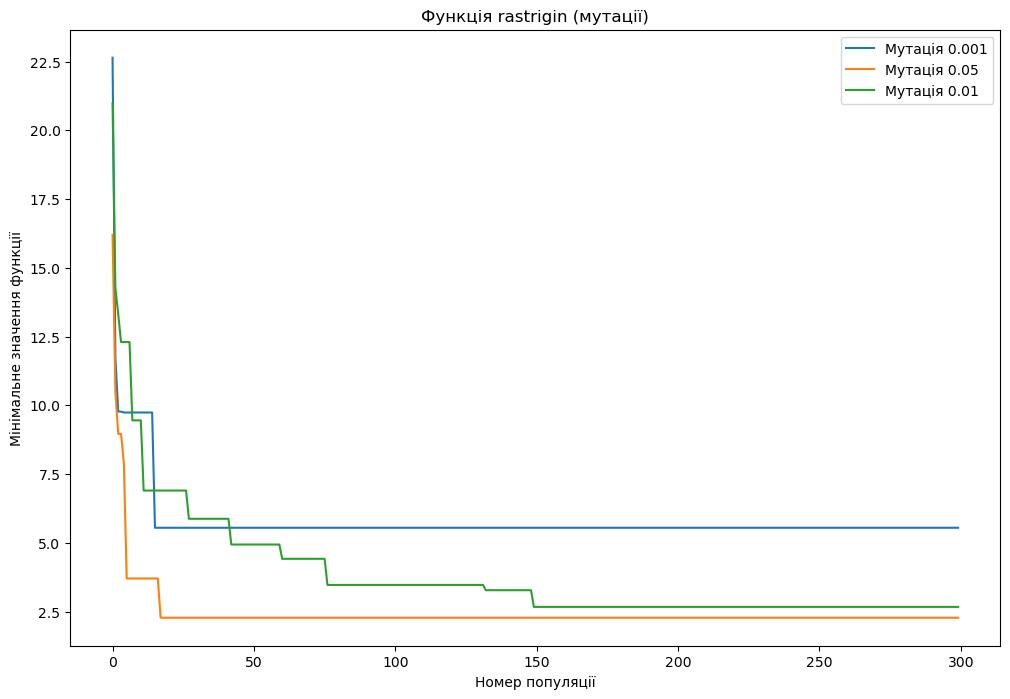

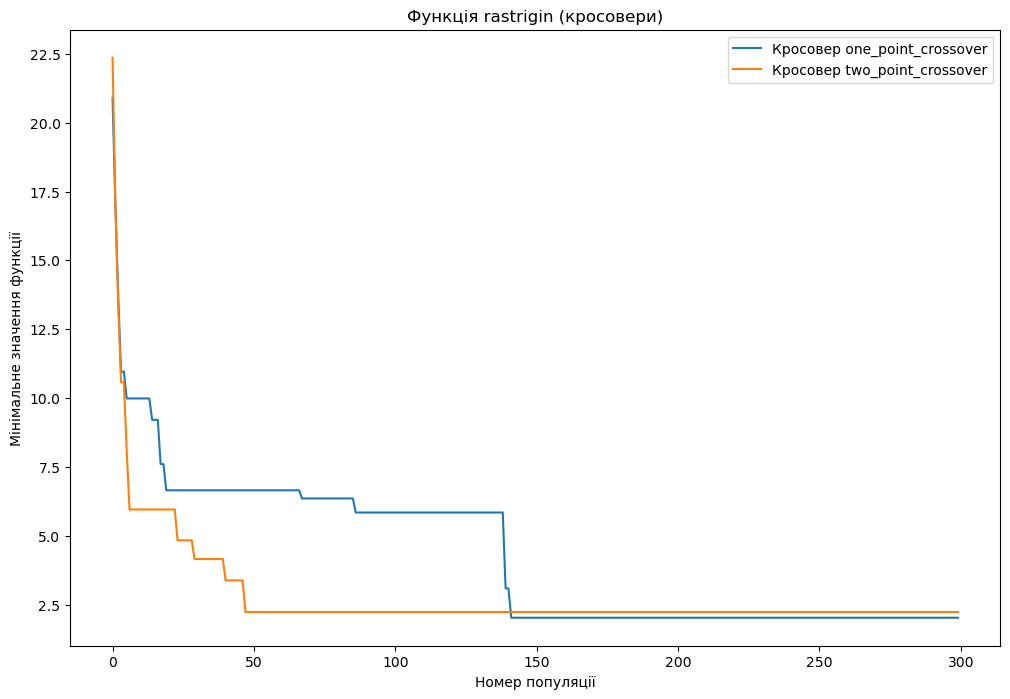

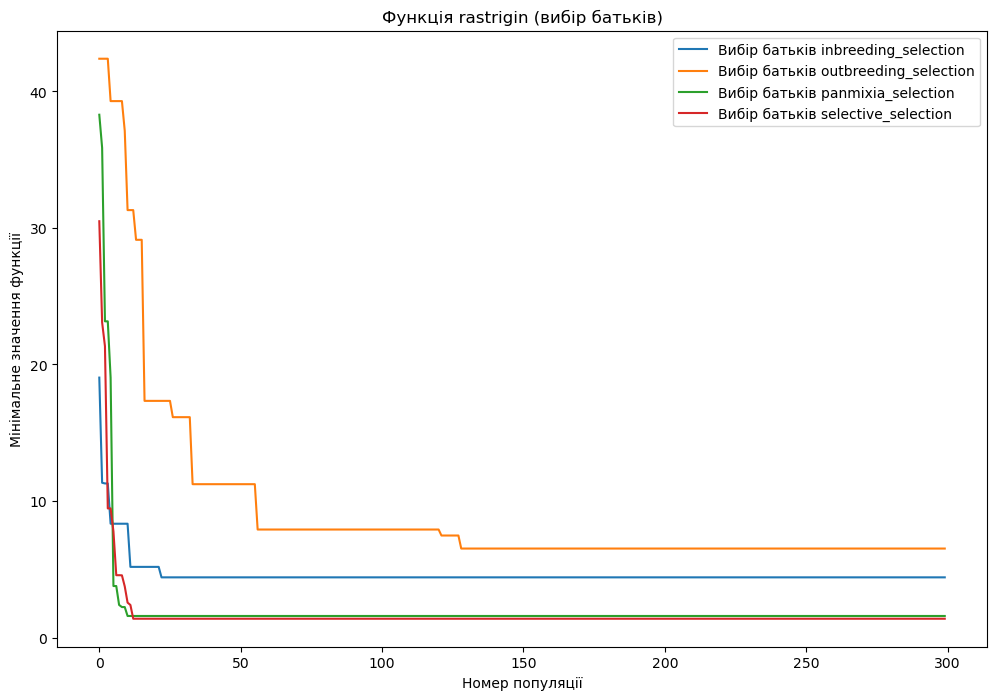

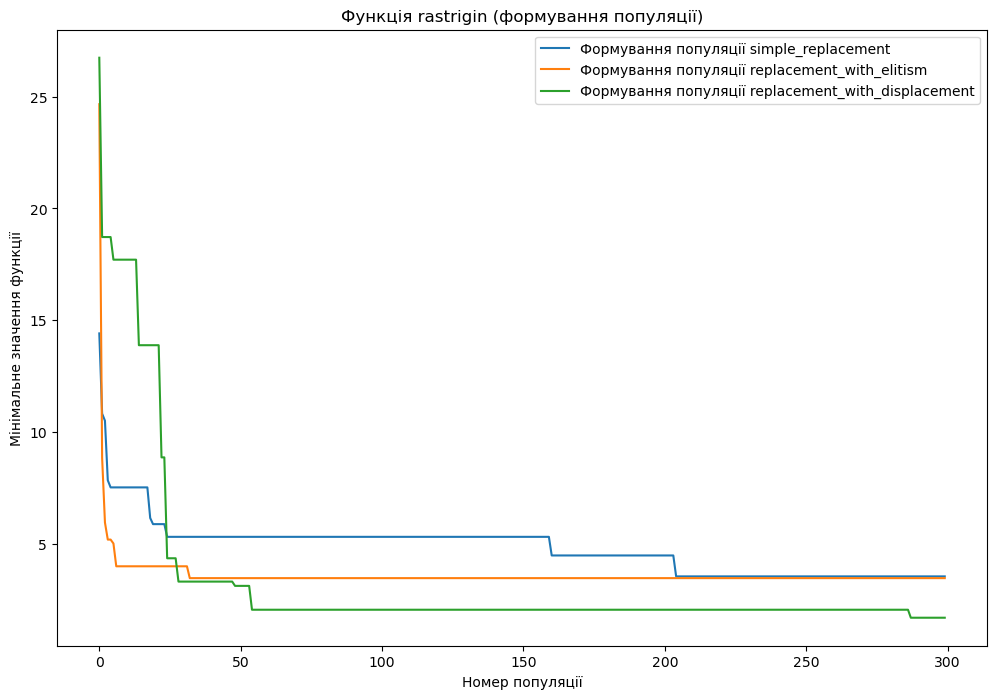

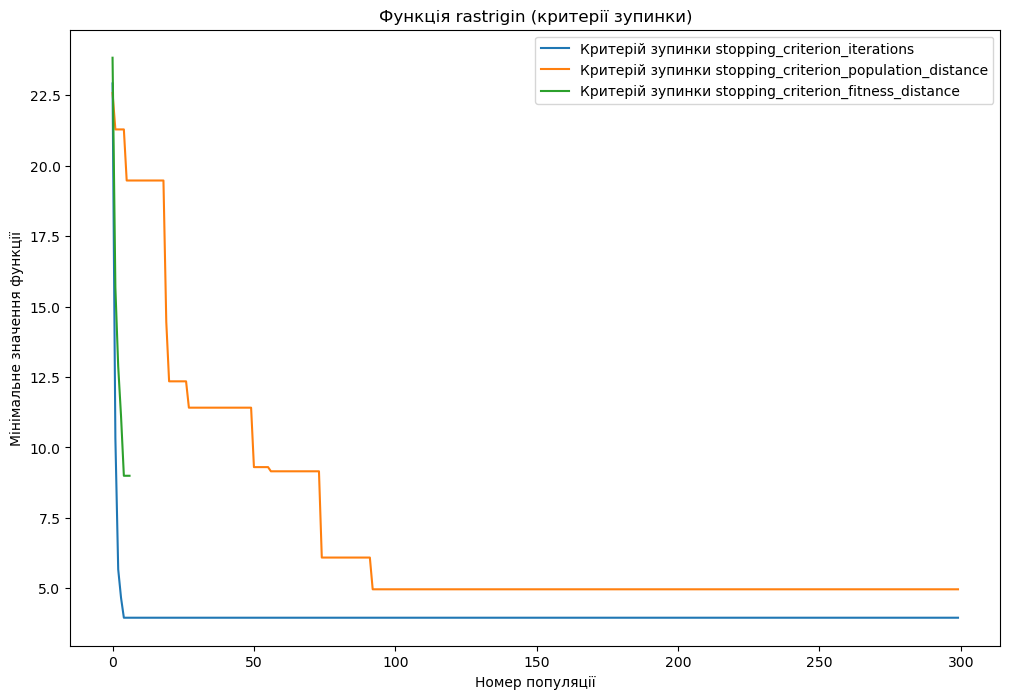

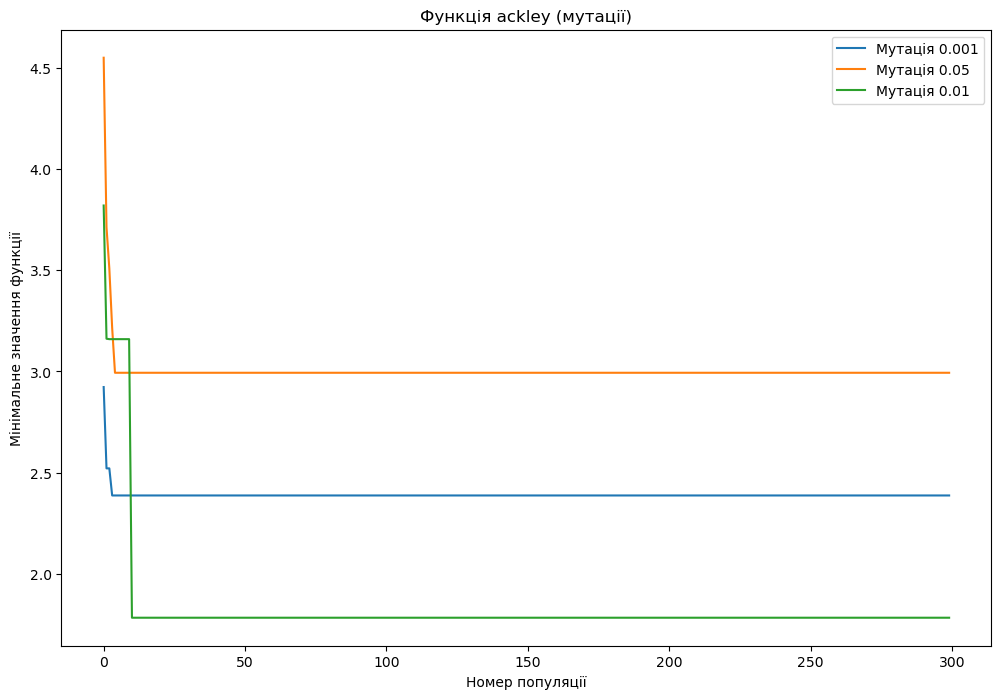

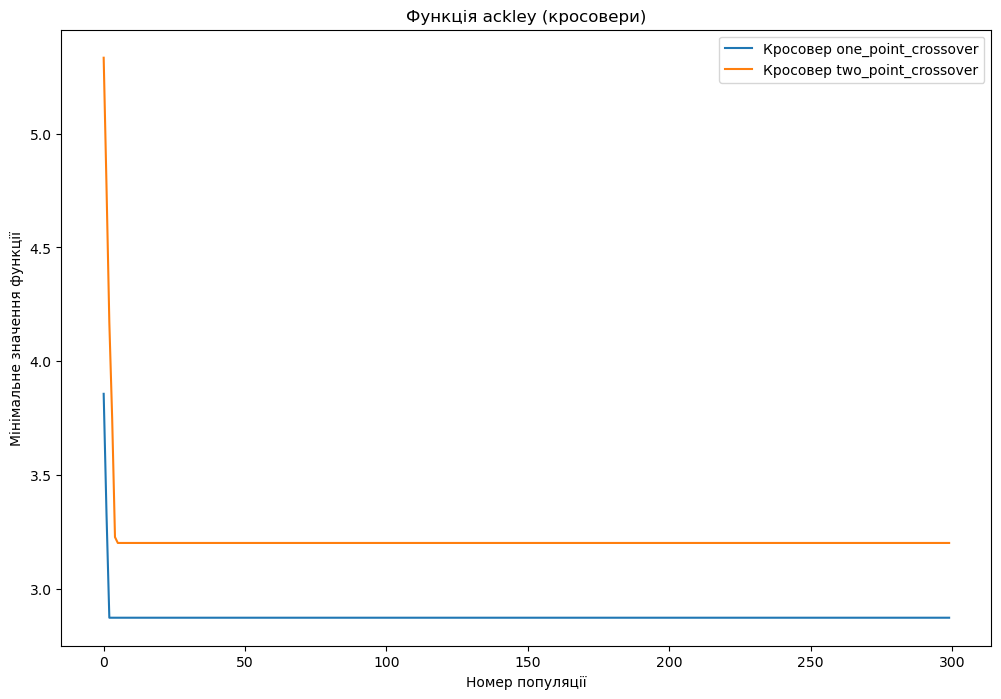

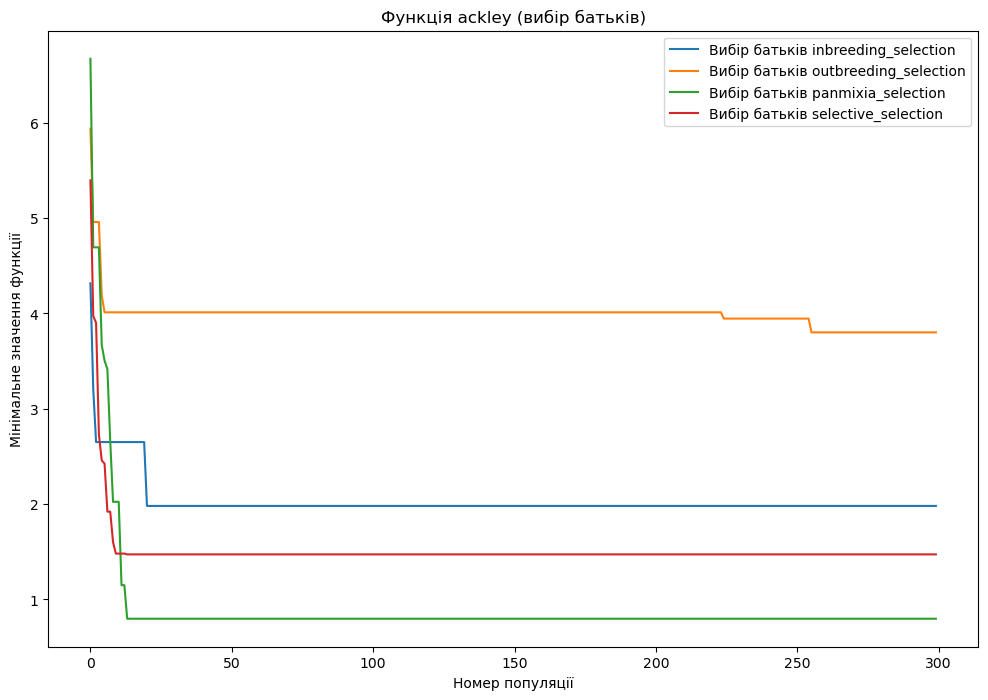

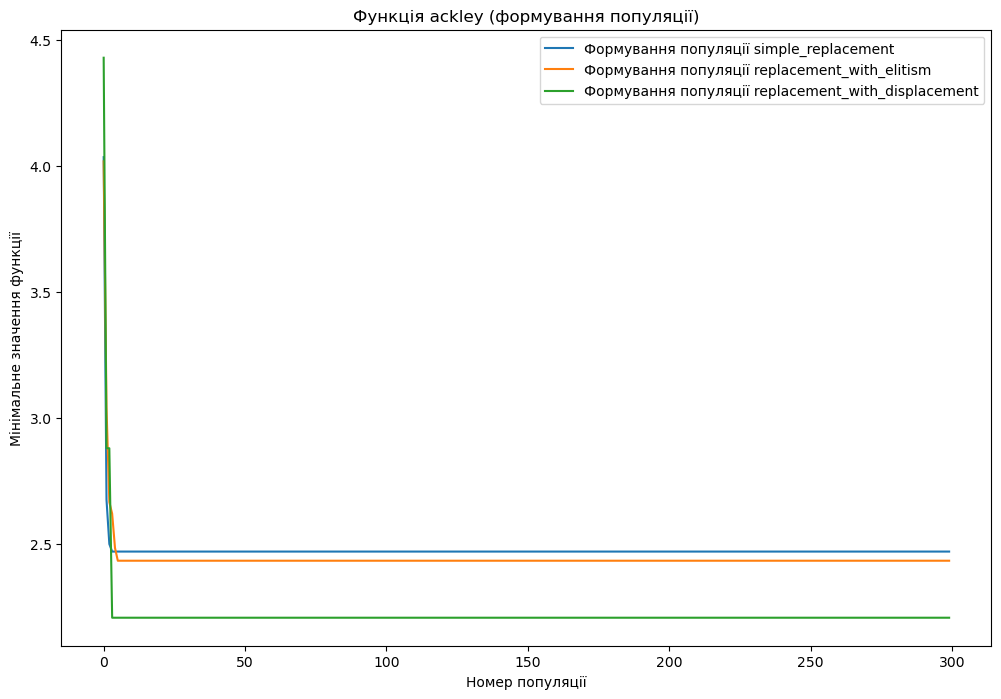

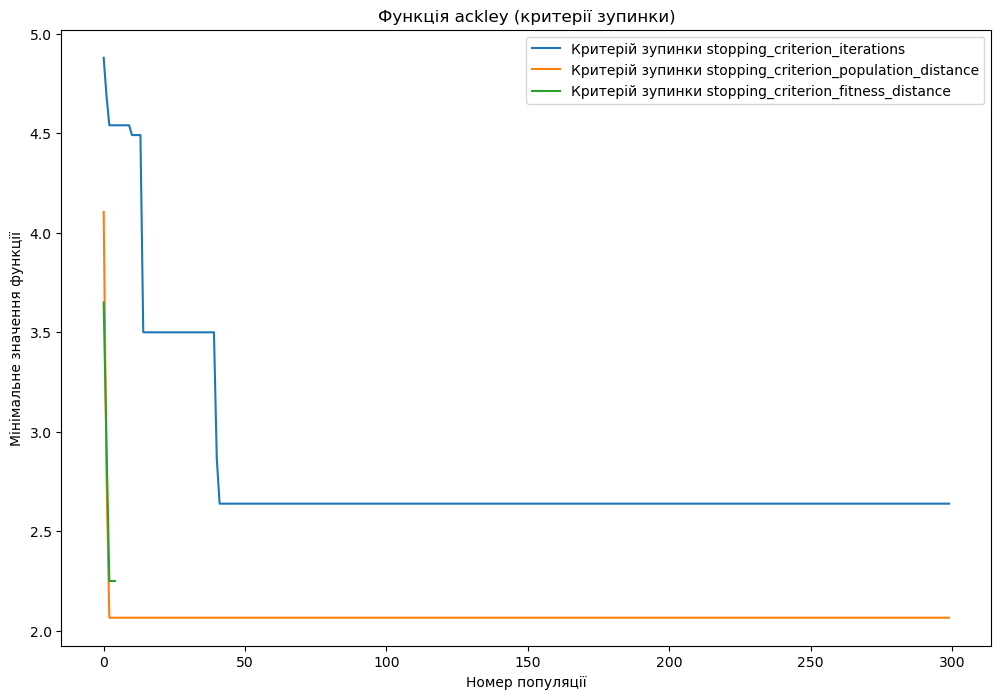

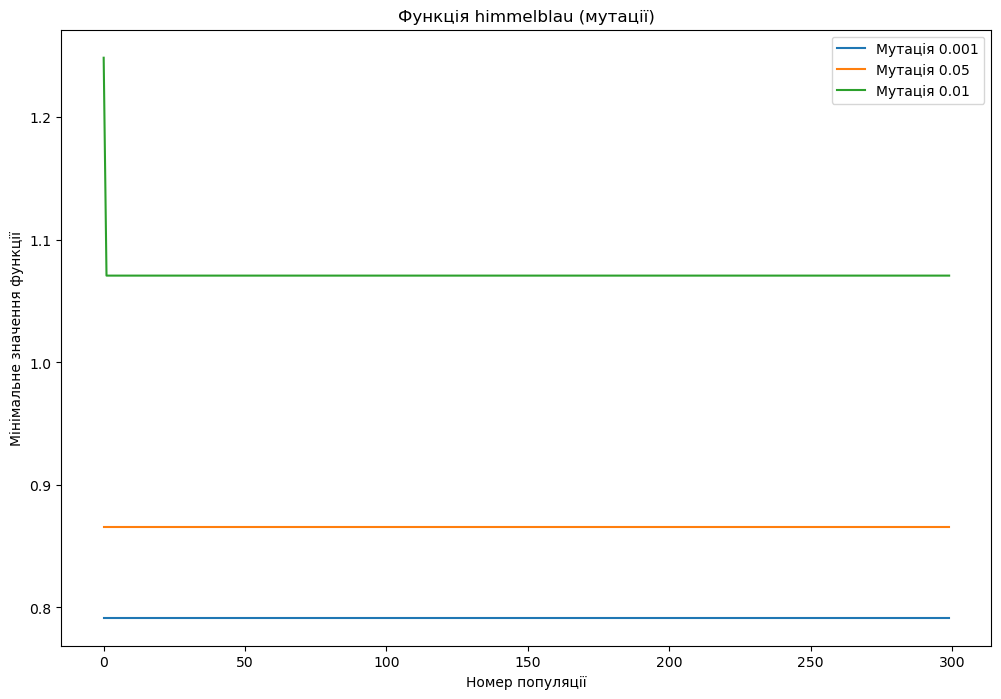

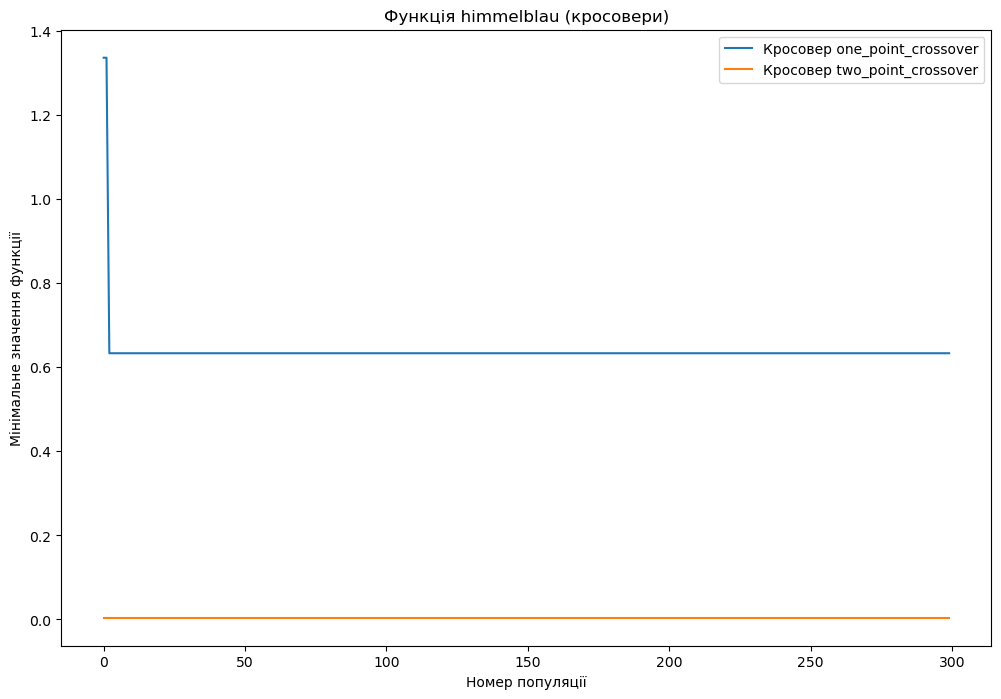

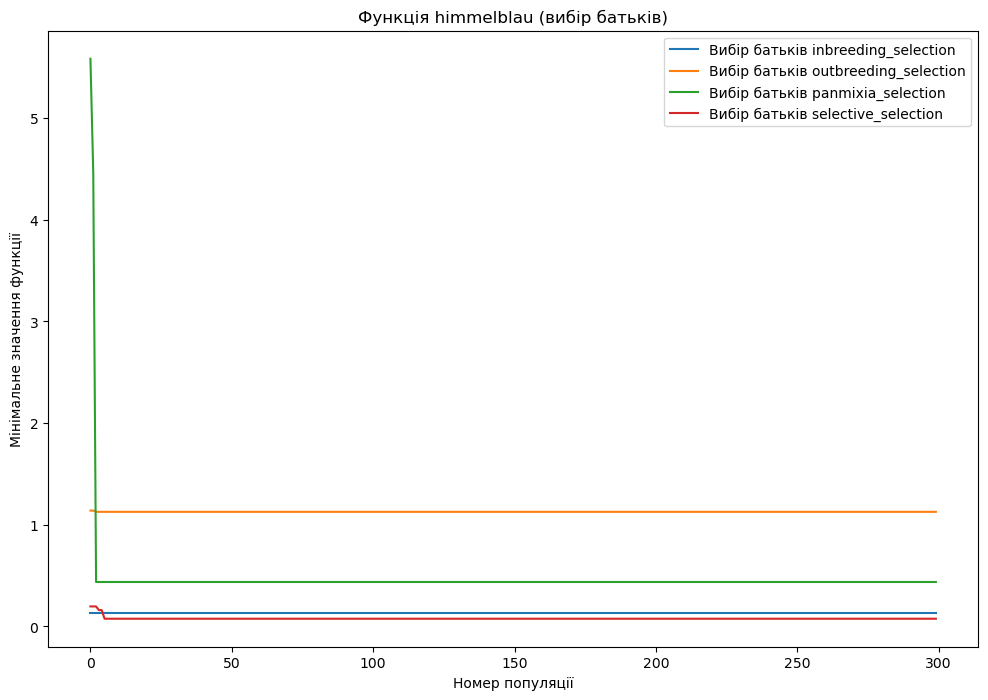

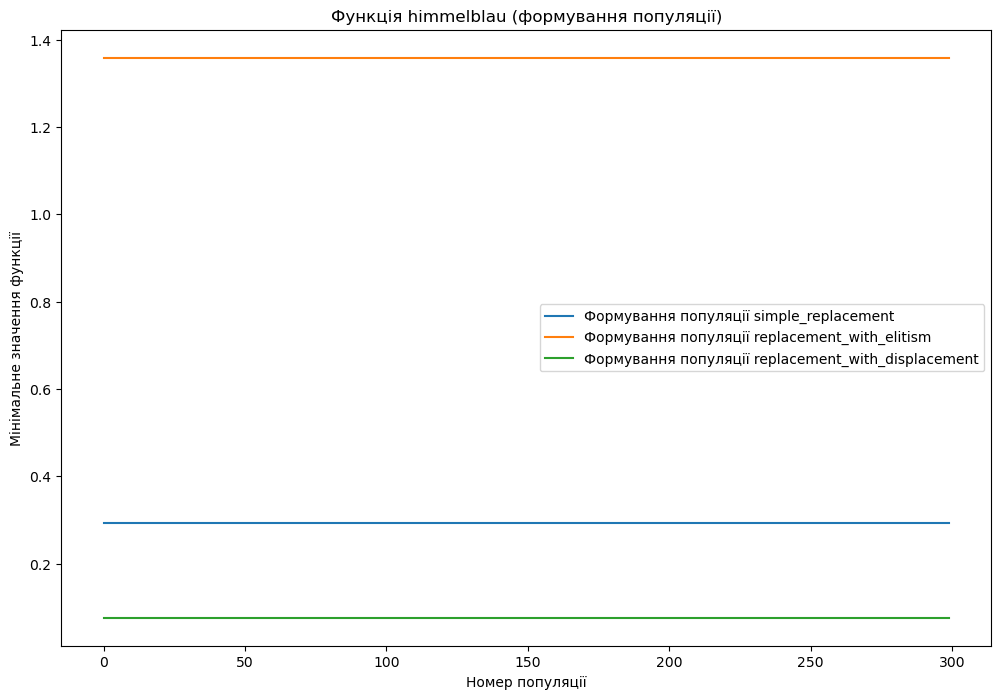

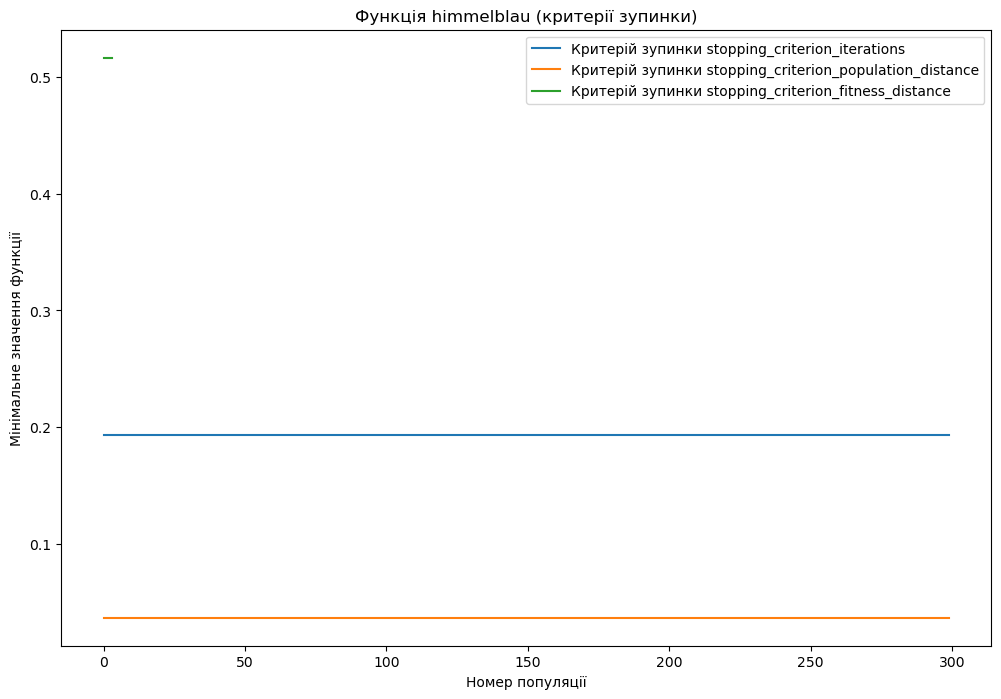

In [40]:
def run_genetic_algorithm(fitness_function, num_params, population_size, mutation_rate, crossover_function,
                          selection_function, replacement_function, max_iterations, min_distance,
                          stopping_criterion_function):
    population = [np.random.uniform(-5, 5, num_params) for _ in range(population_size)]
    iterations = 0
    min_values = []

    while not stopping_criterion_function(iterations, max_iterations, population, min_distance, fitness_function):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = selection_function(population, fitness_function)
            child1, child2 = crossover_function(parent1, parent2)
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)
            new_population.extend([child1, child2])
        population = replacement_function(population, new_population, fitness_function)
        min_values.append(min([fitness_function(individual) for individual in population]))
        iterations += 1

    return min_values


def plot_graphs(fitness_function, num_params, title, parameter_values, parameter_name, parameter_index,
                max_iterations=300):
    plt.figure(figsize=(12, 8))
    plt.title(title)

    for parameter_value in parameter_values:
        parameters = [POPULATION_SIZE, 0.01, one_point_crossover, inbreeding_selection, simple_replacement,
                      MAX_ITERATIONS, MIN_DISTANCE, stopping_criterion_iterations]
        parameters[parameter_index] = parameter_value
        min_values = run_genetic_algorithm(fitness_function, num_params, *parameters)
        if isinstance(parameter_value, str) or isinstance(parameter_value, float):
            plt.plot(min_values, label=f"{parameter_name} {parameter_value}")
        else:
            plt.plot(min_values, label=f"{parameter_name} {parameter_value.__name__}")

    plt.xlabel("Номер популяції")
    plt.ylabel("Мінімальне значення функції")
    plt.legend()
    plt.show()


for i, fitness_function in enumerate(fitness_functions):
    plot_graphs(fitness_function, num_params_list[i], f"Функція {fitness_function.__name__} (мутації)", MUTATION_RATES,
                "Мутація", 1)
    plot_graphs(fitness_function, num_params_list[i], f"Функція {fitness_function.__name__} (кросовери)",
                CROSSOVER_FUNCTIONS, "Кросовер", 2)
    plot_graphs(fitness_functions[i], num_params_list[i], f"Функція {fitness_function.__name__} (вибір батьків)",
                SELECTION_FUNCTIONS,
                "Вибір батьків", 3)
    plot_graphs(fitness_functions[i], num_params_list[i], f"Функція {fitness_function.__name__} (формування популяції)",
                REPLACEMENT_FUNCTIONS, "Формування популяції", 4)
    plot_graphs(fitness_function, num_params_list[i], f"Функція {fitness_function.__name__} (критерії зупинки)",
                STOPPING_CRITERION_FUNCTIONS, "Критерій зупинки", 7)